In [1]:
import arviz as az
import matplotlib.pylab as plt
import numpy as np
from scipy.special import erf
import sys
sys.path.append('./../figures/')
from makeCorner import *

First, load the output of our inference as an arviz InferenceData object:

In [2]:
data = az.from_netcdf("effective_spin_doubleGaussians.cdf")
az.summary(data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bq,1.893,1.030,0.112,3.829,0.015,0.012,5512.0,3571.0,1.0
logsig_chi_high,-1.226,0.120,-1.464,-1.023,0.002,0.001,3351.0,1985.0,1.0
logsig_chi_low,-0.586,0.399,-1.315,-0.000,0.007,0.005,3277.0,3506.0,1.0
min_log_neff,2.176,0.300,1.601,2.663,0.005,0.003,4677.0,4607.0,1.0
mu_chi_high,0.048,0.016,0.017,0.077,0.000,0.000,4651.0,3871.0,1.0
mu_chi_low,0.224,0.389,-0.524,0.972,0.007,0.006,3359.0,2455.0,1.0
nEff_inj_per_event,93.290,25.628,48.914,142.474,0.390,0.276,4117.0,4635.0,1.0
zeta_high,0.922,0.067,0.794,1.000,0.001,0.001,3053.0,2040.0,1.0


The contents of this file are the following:

| Parameter | Description |
| :-------- | :---------- |
| `mu_chi_high` | Mean of the dominant (comprising more than 50% of the population) $\chi_\mathrm{eff}$ sub-population |
| `logsig_chi_high` | Log10 of the standard deviation of the dominant $\chi_\mathrm{eff}$ sub-population |
| `mu_chi_low` | Mean of the subdominant (comprising less than 50% of the population) $\chi_\mathrm{eff}$ sub-population |
| `logsig_chi_low` | Log10 of the standard deviation of the subdominant $\chi_\mathrm{eff}$ sub-population |
| `zeta_high` | Fraction of BBHs contained within the dominant sub-population |
| `bq` | Power-law index on the conditional secondary mass distribution $p(m_2\|m_1)$|
| `min_log_neff` | Log10 of the minimum number of effective samples (taken across events) for the proposed hyperparameter |
| `nEff_inj_per_event` | The effective number of found injections per observed event at the proposed hyperparameter (should be $\gg 4$) |

Next, plot our various chains to inspect convergence:

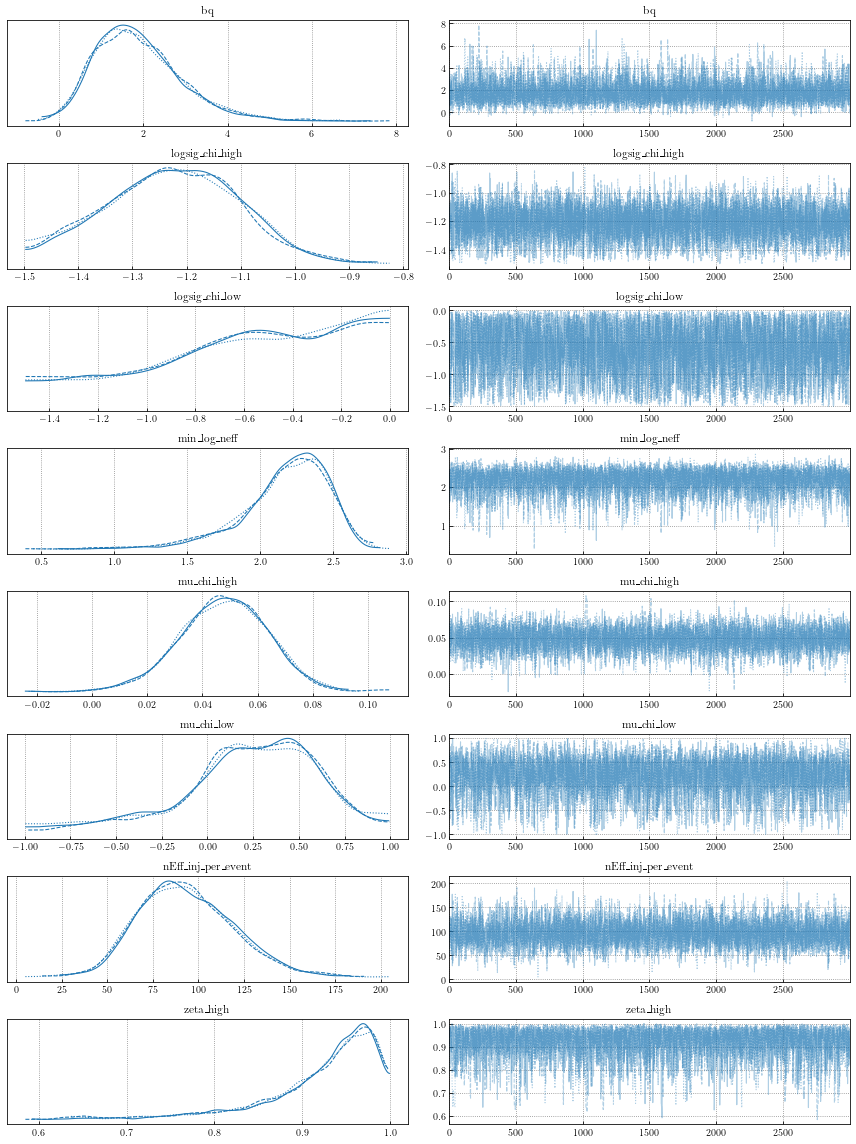

In [3]:
az.plot_trace(data, compact=True)
plt.tight_layout()
plt.show()

Let's make a corner plot showing posteriors on our parameters:

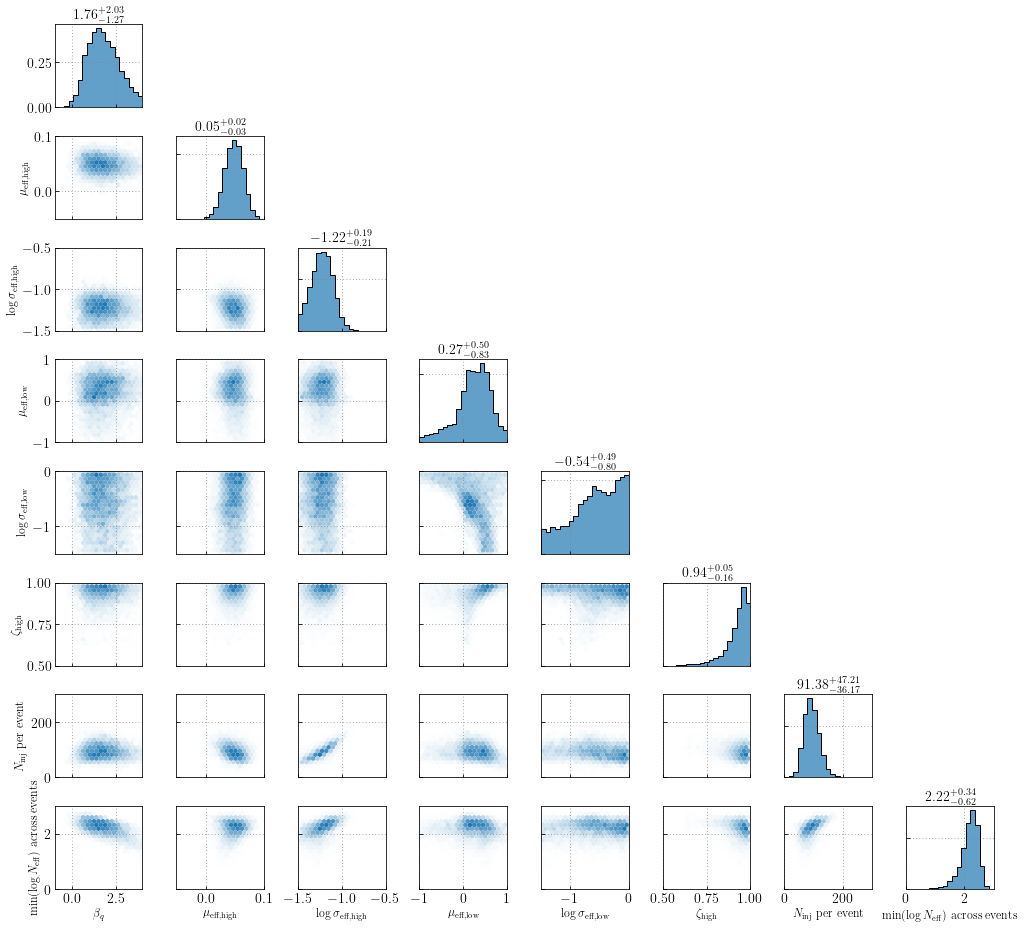

In [4]:
fig = plt.figure(figsize=(14,13))

stacked_samples = data.posterior.stack(draws=("chain", "draw"))
toPlot = {
    "bq":{"data":stacked_samples.bq,"plot_bounds":(-1,4),"label":r"$\beta_q$"},
    "mu_chi_high":{"data":stacked_samples.mu_chi_high,"plot_bounds":(-0.05,0.1),"label":r"$\mu_\mathrm{eff,high}$"},
    "logsig_high":{"data":stacked_samples.logsig_chi_high,"plot_bounds":(-1.5,-0.5),"label":r"$\log\sigma_\mathrm{eff,high}$"},
    "mu_chi_low":{"data":stacked_samples.mu_chi_low,"plot_bounds":(-1,1),"label":r"$\mu_\mathrm{eff,low}$"},
    "logsig_low":{"data":stacked_samples.logsig_chi_low,"plot_bounds":(-1.5,0),"label":r"$\log\sigma_\mathrm{eff,low}$"},
    "zeta_high":{"data":stacked_samples.zeta_high,"plot_bounds":(0.5,1),"label":r"$\zeta_\mathrm{high}$"},
    "neff_inj_per_event":{"data":stacked_samples.nEff_inj_per_event,"plot_bounds":(0,300),"label":r"$N_\mathrm{inj}$ per event"},
    "min_log_neff":{"data":stacked_samples.min_log_neff,"plot_bounds":(0,3),"label":r"$\min(\log N_\mathrm{eff})$ across events"}
}

plot_corner(fig,toPlot,'#1f78b4',labelsize=12)
plt.tight_layout()
plt.show()

Finally, let's make a "trace plot" showing the set of $\chi_\mathrm{eff}$ distributions corresponding to the above samples:

In [5]:
def gaussian(samples,mu,sigma,lowCutoff,highCutoff):
    
    """
    Function defining the probability density due to a truncated Gaussian
    """
    
    a = (lowCutoff-mu)/np.sqrt(2*sigma**2)
    b = (highCutoff-mu)/np.sqrt(2*sigma**2)
    norm = np.sqrt(sigma**2*np.pi/2)*(-erf(a) + erf(b))
    return np.exp(-(samples-mu)**2/(2.*sigma**2))/norm

In [6]:
# Define a grid of effective spins
grid = np.linspace(-1,1,1000)

# Choose a number of traces to draw
nTraces = 500

# Instantiate an array to hold a collection of traces
p_chi = np.zeros((nTraces,grid.size))

# For a random set of posterior samples, compute and store the corresponding probability densities across our grid
random_indices = np.random.choice(np.arange(stacked_samples.mu_chi_high.size),size=nTraces,replace=False)
for i,ind in enumerate(random_indices):
    
    zeta_high = stacked_samples.zeta_high.values[i]
    mu_chi_high = stacked_samples.mu_chi_high.values[i]
    logsig_chi_high = stacked_samples.logsig_chi_high.values[i]
    mu_chi_low = stacked_samples.mu_chi_low.values[i]
    logsig_chi_low = stacked_samples.logsig_chi_low.values[i]
    
    p_chi[i,:] = zeta_high*gaussian(grid,mu_chi_high,10.**logsig_chi_high,-1,1) \
        + (1.-zeta_high)*gaussian(grid,mu_chi_low,10.**logsig_chi_low,-1,1)

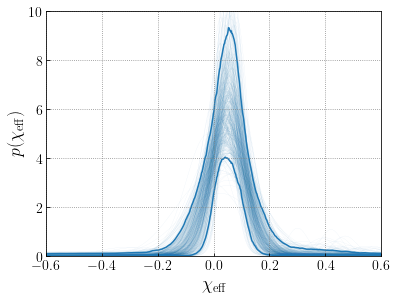

In [7]:
fig,ax = plt.subplots(figsize=(6,4.5))

# Plot individual traces
ax.plot(grid,p_chi.T,color='#1f78b4',lw=0.15,alpha=0.15,zorder=0)

# Also plot 5% and 95% credible bounds
ax.plot(grid,np.quantile(p_chi,0.05,axis=0),color='#1f78b4',zorder=1,label='Two-Component Mixture')
ax.plot(grid,np.quantile(p_chi,0.95,axis=0),color='#1f78b4',zorder=1)

ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,10)
ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)

plt.show()